
 #    **POMPOM**: **P**arton ev**O**lution  with **M**atrices - **P**olynomials, l**O**garithms, and **M**ore
Authors:  Juliane Haug, Oliver Schüle, and Fabian Wunder

Affiliation: University of Tübingen

Date: 25. April 2024

Reference: "A semi-analytical x-space solution for parton evolution --- Application to non-singlet and singlet DGLAP equation"

Version: Python 3.9.13

$\,$

# Usage of this Notebook


* This Python script provides a basic implementation of the POMPOM method applied to the DGLAP equation in leading order.
* For details of the calculation go through the notebook step-by-step after reading section 3 of our corresponding paper.
* Unless otherwise noted, all equation numbers refer to our corresponding paper.
* The last section defines **GRV98_POMPOM_Evolution(N_basis_functions_plot, CutoffFct_plot)** which evolves the default initial conditions from GRV98 (Eur. Phys. J. C 5 (1998) 461 [hep-ph/9806404]) to 5 different scales and creates a plot analogous to figure 4.
* To evolve individual PDFs, you can run all code apart from the last section (Full Example: Evolution of the GRV98 PDF-Set). The evolution is then performed using **Evolution_Complete_(Non)Singlet(mu, mu0, pdfs_at_mu0, cutofflog, cutoffxmin, cutoffxmaxfct=CutoffFct, order_alphaS=0)**, which takes and returns the pdfs as vectors of coefficients $a_{mn}$.
*   Where possible, the naming of functions corresponds to the Mathematica implementation.
* Note that currently, pyPOMPOM only contains functions for the POMPOM evolution of a PDF set, and the generation of a plot similar to figure 4. The Mathematica implementation contains the generation of all figures, as well as a simple evolution in Mellin-space.



$\,$

# Import Required Packages

Import packages, define symbolic parameters and functions, and set memory variables

In [ ]:
 # Import basic math
import math

 # import numpy, doi: 10.1038/s41586-020-2649-2
from numpy import pi
import numpy as np

 # import Sympy for symbolic calculations, https://github.com/sympy/sympy.github.com
import sympy as sp
from sympy.interactive import printing
printing.init_printing(use_latex = True)

 # import scipy, doi: 10.1038/s41592-019-0686-2
import scipy.integrate as integrate
import scipy.linalg as scipylin
import scipy.linalg.blas as blas
from   scipy.special import zeta as zeta_numeric

 # import matplotlib, doi: 10.1109/MCSE.2007.55
import matplotlib.pyplot as plt

 # time tracking ( to track speed, use time.time() )
import time

 # definition of symbolic parameters
x,CF,Tf,CA,Nf = sp.symbols("x, C_F, T_f, C_A, N_f")
m,n,M,N       = sp.symbols("m,n,M,N", positive=True, integer=True)
xi            = sp.Symbol( "xi", real = True)
logx          = sp.Symbol( "logx")
dummy         = sp.Symbol( "x_d")

 # definition of symbolic functions
HarmonicNumber = sp.Function('H_N')
zeta           = sp.Function('zeta')
Matrix         = sp.Function('M')
Matrix_11      = sp.Function('M_1_1')
I0             = sp.Function('I_0')
I1             = sp.Function('I_1')
I2             = sp.Function('I_2')
I3             = sp.Function('I_3')
I4             = sp.Function('I_4')


 # memory to avoid multiple evaluations of time consuming functions
memory_SplitFunMatrix         = {}
memory_SplitFunMatrix_numeric = {}
memory_PMatrix                = {}
memory_PMatrix_NonSinglet     = {}
memory_GRV98Vectors = {}
memory_basis = {}

 # resets the memory variables
def reset_memory():
    global memory_SplitFunMatrix, memory_SplitFunMatrix_numeric,\
           memory_PMatrix, memory_PMatrix_NonSinglet,           \
           memory_GRV98Vectors, memory_basis
    memory_SplitFunMatrix = {}
    memory_SplitFunMatrix_numeric = {}
    memory_PMatrix = {}
    memory_PMatrix_NonSinglet = {}
    memory_GRV98Vectors = {}
    memory_basis = {}

$\;\;\;\;\;\;$

# Selection of Cut-Off Function and Resulting Basis

The cut-off function determines which powers of $x$ and $\log x$ are included in the basis functions. As a default, we use the following function:

In [ ]:
 # Standard Cutoff, name will later be required as index for the memory
def CutoffFct(i,j, return_tuple_with_cutoff_name = False):
    if return_tuple_with_cutoff_name:
        return i-j, "StandardCutoff"
    else:
        return i-j

This cut-off function is employed as follows:

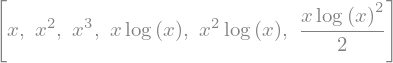

In [ ]:
 # Returns a list of basis functions with respect to the chosen cut-off function
def BasisFunctions(cutofflog, cutoffnmin, cutoffnmaxfct=CutoffFct):
    return [x**i *  (sp.log(x))**j / sp.factorial(j)
            for  j in range(0,cutofflog + 1) for i in range(cutoffnmin, cutoffnmaxfct(cutofflog,j) + 1  )]

 # example
display(BasisFunctions(3,1))

Thus, our cut-off function includes all basis functions $x^n \frac{\ln^m x}{m!}$ where $n+m \le$  cutofflog.
Hence, we have terms of the form

$\quad x^{(\text{big})} \log^{(\text{small})}  \, \rightarrow$  important near $x=1$, small near $x=0$

$\quad x^{(\text{small})} \log^{(\text{big})} \, \rightarrow$  small near $x=1$, important near $x=0$

$\quad x^{(\text{medium})} \log^{(\text{medium})}$

but no terms of the form

$\quad x^{(\text{big})} \log^{(\text{big})} \, \rightarrow$ small for $0<x<1$, can be neglected for faster numerics



A cut-off of this form is better than a quadratic cut-off where cutofflog = cutoffx, as in the quadratic cut off many terms $x^{(\text{big})} \log^{(\text{big})}$ which yield only small corrections are taken into account. The quadratic cut-off can be applied via


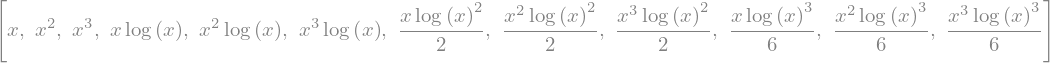

In [ ]:
 # Quadratic Cutoff
def QuadraticCutoffFct(i,j, return_tuple_with_cutoff_name = False):
    if return_tuple_with_cutoff_name:
        return i, "QuadraticCutoffFct"
    else:
        return i

 # example
display(BasisFunctions(3,1,QuadraticCutoffFct))

For the numerical analysis in our paper, we used the refined cutoff given by eq. (4.1), which depends on two parameters controlling the relative importance of log-terms ($\alpha$) and x-terms ($\beta$),

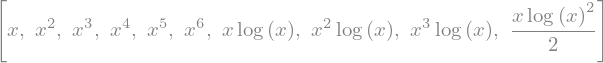

In [ ]:
 # Refined Cutoff with two parameters
def CutoffFctLinear(alpha, beta, i,j, return_tuple_with_cutoff_name = False):
        if (alpha + 1)*j > i:
            output = math.floor( (i-j)/alpha )
        else:
            output =  math.floor( - beta*j + (1+ beta)/(1+alpha) * i )
        if return_tuple_with_cutoff_name:
             return output, "RefinedCutoff: " + str(alpha) + "," + str(beta)
        else:
             return output

 # example
display(BasisFunctions(3,1, lambda i,j: CutoffFctLinear(1, 3, i, j )))

The following function returns the cutofflog which would result in a specific number of basis functions that obey a given cutoff function

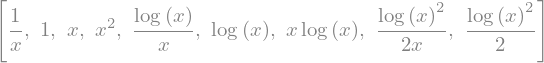

In [ ]:
 # Returns the best cutofflog for N_basisfunctions with respect to the chosen cutoffnmaxfct
def CutoffLogFromTotalNumberOfBasisFunctions(N_basisfunctions, cutoffnmaxfct, cutoffnmin=-1):
    cutofflog = -1
    sum = 0
    while sum < N_basisfunctions:
        cutofflog += 1
        sum = len(BasisFunctions(cutofflog, cutoffnmin, cutoffnmaxfct))
    if sum > N_basisfunctions:
        cutofflog -= 1
    return cutofflog

 # example
N_basis_functions_example = 10
cutoffnmin_example = -1
resulting_cutoff = CutoffLogFromTotalNumberOfBasisFunctions( N_basis_functions_example, CutoffFct, cutoffnmin_example )
display(BasisFunctions( resulting_cutoff, cutoffnmin_example))

$\;\;\;\;\;\;$

# The $\mathcal{P}$-Matrix

Using ansätze in the form of eq. (3.11) for the singlet PDFs, the components of the integrated 2x2 splitting matrix on the right-hand side of eq. (2.8) take form given below.
\
\
Note that here, the sum over coefficients $\sum_{m=0,n=-1}^{\infty} a_{m,n}^{(q^S/g)}\!\left(\mu^2\right)$ is to be implicitly understood as written in front of every term.
\
\
Additionally, the components were written in terms of the master integrals
\
$I_0(m,n) = x^n \int_x^1  d \xi\, \delta(1-\xi) \frac{\ln ^m (x/\xi)}{m!} ,$

$I_1(m,n) = x^n \int_x^1  d \xi \frac{\xi^{-n} -1 }{1-\xi } \frac{\ln ^m (x/\xi)}{m!} ,$

$I_2(m,n) = x^n \int_x^1  d \xi \frac{\ln ^m (x/\xi)  - \ln ^m (x)    }{m!(1-\xi) } ,$

$I_3(m,n) = x^n \int_x^1  d \xi \frac{\xi^{-n} \ln ^m (x/\xi) }{m!} ,$

$I_4(m,n) = -x^n \int_0^x  d \xi \frac{1 }{1-\xi } \frac{\ln ^m (x)}{m!} = \ln(1-x)  \frac{\ln ^m (x) x^n }{m!} . $
\
Note that the master integrals $I_1,I_2$ and $I_3$ are given in appendix A of our paper, while the fourth master integral is newly introduced here for ease of calculation.

In [ ]:
 # The components of the integrated kernel, the master integrals I0,...I4 have not yet been inserted
def splitFunMatrix11(M, N, m, n, CF, CA, Nf, Tf, I0, I1, I2, I3, I4):
    return ( (3*CF*I0(M, N, m, n))/2 + CF*I1(M, N-1, m, -1 + n) + (CF*I1(M, N+1, m, 1 + n)) +
                             CF*I2(M, N-1, m, -1 + n) + (CF*I2(M, N+1, m, 1 + n)) + CF*I4(M, N-1, m, -1 + n) + (CF*I4(M, N+1, m, 1 + n)) )

def splitFunMatrix12(M, N, m, n, CF, CA, Nf, Tf, I0, I1, I2, I3, I4):
    return 4*Nf*Tf*I3(M, N-1, m, -1 + n) - 4*Nf*Tf*I3(M, N, m, n) + (2*Nf*Tf*I3(M, N+1, m, 1 + n))

def splitFunMatrix21(M, N, m, n, CF, CA, Nf, Tf, I0, I1, I2, I3, I4):
    return CF*I3(M, N, m, n) - (2*CF*I3(M, N+1, m, 1 + n)) + (2*CF*I3(M, N+2, m, 2 + n))

def splitFunMatrix22(M, N, m, n, CF, CA, Nf, Tf, I0, I1, I2, I3, I4):
    return ( ((11*CA - 4*Nf*Tf)*I0(M, N, m, n))/6 + 2*CA*I1(M, N, m, n) + 2*CA*I2(M, N, m, n) - 2*CA*I3(M, N-1, m, -1 + n) + 2*CA*I3(M, N, m, n)
                  - (2*CA*I3(M, N+1, m, 1 + n)) + (2*CA*I3(M, N+2, m, 2 + n)) + 2*CA*I4(M, N, m, n) )

The Matrix itself is therefore of the form

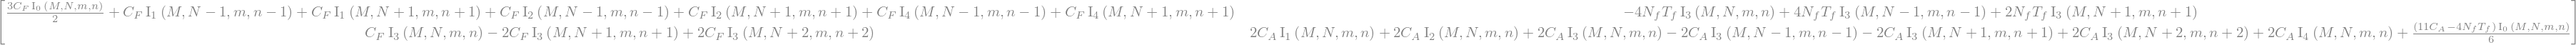

In [ ]:
 # The splitting function matrix expressed through the master integrals
def GeneralSplitFunMatrix(M, N, m, n, CF, CA, Nf, Tf, I0, I1, I2, I3, I4):
      # 2x2 matrix, consisting of the 4 entries:
     return np.array([ [  splitFunMatrix11(M, N, m, n, CF, CA, Nf, Tf, I0, I1, I2, I3, I4),
                          splitFunMatrix12(M, N, m, n, CF, CA, Nf, Tf, I0, I1, I2, I3, I4)],
                        [ splitFunMatrix21(M, N, m, n, CF, CA, Nf, Tf, I0, I1, I2, I3, I4),
                          splitFunMatrix22(M, N, m, n, CF, CA, Nf, Tf, I0, I1, I2, I3, I4)] ] )

 # Symbolic Matrix with only four arguments
GeneralSplitFunMatrix_symbolic = lambda M,N,m,n: sp.Matrix(GeneralSplitFunMatrix(M, N, m, n, CF, CA, Nf, Tf, I0, I1, I2, I3, I4))

 # show
GeneralSplitFunMatrix_symbolic( M,N,m,n )

To insert the master integrals, we write them as $I_i(m,n) = \sum_{M=0}^{\infty} \sum_{N=-1}^{\infty} c^i_{MN}(m,n) \
\frac{\ln^M(x) x^N}{m!}$, where the coefficients $c^i_{MN}$ contain Heaviside Theta functions and Kronecker-Delta to restrict the summation indices if needed. This allows us to replace the master integrals with only the coefficients, while keeping in mind that the sums $\sum_{M=0}^{\infty} \sum_{N=-1}^{\infty} \frac{\ln^M(x) x^N}{m!}$ should be written in front of the integrand.

In [ ]:
 # Kronecker delta function
def Delta(arg1, arg2):
     return 1 if arg1 == arg2 else 0

 # Heaviside function
def Theta(arg1):
     return 1 if arg1 >= 0 else 0

# Harmonic Numbers
def HarmNum(n, k):
     return  sum( 1/j**k for j in range(1, n+1))



 # solution of the I0-Integral
def I0Sol(M,N,m,n,zeta=zeta):
     return Delta(M,m)*Delta(N,n)

 # solution of the I1-Integral
def I1Sol(M,N,m,n,zeta=zeta) :
     return ( ((
               #only if N = n
               - (HarmNum(-n,m-M+1)               if  ( Theta(-2-n)*Theta(m-M)  == 1 ) else 0)
               - (1                               if  ( Delta(n,-1)*Theta(m-M)  == 1 ) else 0)
               - (HarmNum(n-1,m-M+1)*(-1)**(m-M)  if  ( Theta(m-M)*Theta(n-1)   == 1 ) else 0)
               - (1                               if  ( Theta(n-1)*Delta(M,m+1) == 1 ) else 0))
                                                  if  ( Delta(N,n) ==1 ) else 0)
               #only if N != n
               + ( 1/(N-n)**(m+1)                 if  ( Theta(-N)*Theta(N-(n+1))*Theta(-2-n)*Delta(M,0) ==1 ) else 0 )
               + ( 1/(n-N)**(m+1)*(-1)**m         if  ( Theta(N-1)*Theta(n-1-N)*Theta(n-1)*Delta(M,0)   ==1 ) else 0 )
               + ( 1                              if  ( Delta(n,-1)*Delta(N,n+1)*Delta(M,0)             ==1 ) else 0 )
            )

 # solution of the I2-Integral
def I2Sol(M,N,m,n,zeta=zeta) :
     return (
               (zeta(m+1-M)        if ( Theta(m-1-M)*Delta(N,n)    ==1 ) else 0 )
             + (1/(N-n)            if ( Theta(N-(n+1))* Delta(M,m) ==1 ) else 0 )
             - ((1/(N-n)**(m+1))   if ( Theta(N-(n+1))* Delta(M,0) ==1 ) else 0 )
             )

 # solution of the I3-Integral
def I3Sol(M,N,m,n,zeta=zeta) :
     return (
               - ( 1                 if ( Delta(n,1)*Delta(M,m+1)*Delta(N,1) ==1 ) else 0 )
               - ( 1/(1-n)**(m+1)    if ( Delta(N,1)*Delta(M,0)*Theta(n-2)   ==1 ) else 0 )
               - ( 1/(1-n)**(m+1)    if ( Delta(N,1)*Delta(M,0)*Theta(-n)    ==1 ) else 0 )
               + ( 1/(1-n)**(m+1-M)  if ( Theta(m-M)*Delta(N,n)*Theta(n-2)   ==1 ) else 0 )
               + ( 1/(1-n)**(m+1-M)  if ( Theta(m-M)*Delta(N,n)*Theta(-n)    ==1 ) else 0 )
             )

 # solution of the I4-Integral
def I4Sol(M,N,m,n,zeta=zeta):
     return -1/(N-n) if (Theta(N-n-1)*Delta(M,m) == 1 ) else 0



Inserting the master integrals, the matrix becomes

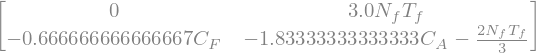

In [ ]:
 # Returns the splitting kernel with symbolic parameters CF, Tf, Nf...
def SymbolicSplitFunMatrix(M,N,m,n):
     # check if the calculation has been made before
    global memory_SplitFunMatrix
    if (M,N,m,n) in memory_SplitFunMatrix:
        return memory_SplitFunMatrix[(M,N,m,n)]

     # if not, insert master integrals
    else:
        result = sp.Matrix( GeneralSplitFunMatrix(M, N, m, n, CF, CA, Nf, Tf, I0Sol, I1Sol, I2Sol, I3Sol, I4Sol) )
        memory_SplitFunMatrix[(M,N,m,n)] = result
        return result

 # example for M=2, N=2, m=2, n=2
SymbolicSplitFunMatrix(2,2,2,2)

As the numerical form of the matrix is required later in the calculation, the following function does basically the same but with numerical values. It seems to be faster than simply inserting the values into the symbolic matrix.

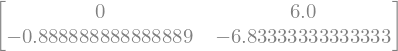

In [ ]:
 # Insertion of the zeta function's numeric value in the master integrals
I0Sol_num = lambda M,N,m,n:  I0Sol( M,N,m,n, zeta_numeric )
I1Sol_num = lambda M,N,m,n:  I1Sol( M,N,m,n, zeta_numeric )
I2Sol_num = lambda M,N,m,n:  I2Sol( M,N,m,n, zeta_numeric )
I3Sol_num = lambda M,N,m,n:  I3Sol( M,N,m,n, zeta_numeric )
I4Sol_num = lambda M,N,m,n:  I4Sol( M,N,m,n, zeta_numeric )


 # numeric computation of the splitting function matrix
def ExplicitSplitFunMatrix(M, N, m, n, Nf_num):

     # check, if the calculation has been made before
    global memory_SplitFunMatrix_numeric
    if (M, N, m, n, Nf_num) in memory_SplitFunMatrix_numeric:
        return memory_SplitFunMatrix_numeric[(M, N, m, n, Nf_num)]

     # if not, insert numerical values in the splitting function matrix
    else:
        result = GeneralSplitFunMatrix(M, N, m, n, 4/3, 3, Nf_num, 1/2, I0Sol_num, I1Sol_num, I2Sol_num, I3Sol_num, I4Sol_num)

        memory_SplitFunMatrix_numeric[(M, N, m, n, Nf_num)] = result
        return result


 # example from above with Nf = 4
display( sp.Matrix(ExplicitSplitFunMatrix(2,2,2,2,4)) )

### Construction of the Singlet $\mathcal{P}$-Matrix

Including the sums we left to be understood implicitly, the integrated splitting function matrix looks like

$\sum_{m=0,n=-\nu}^{\infty} a_{m,n}^{(q^S/g)}\!\left(\mu^2\right) \
\sum_{M=0, N=-\nu}^{\infty}\tilde{c}^{(q^S/g)}_{MN}(n,m) \frac{\ln^M(x) \
x^N}{M!}$


As the the boundaries of the two sets of sums are not dependent on each other, we can interchange the sums to obtain

$\sum_{M=0, N=-\nu}^{\infty} \left[\sum_{m=0,n=-\nu}^{\infty} \
a_{m,n}^{(q^S/g)}\!\left(\mu^2\right) \tilde{c}^{(q^S/g)}_{MN}(n,m)\right] \
\frac{\ln^M(x) x^N}{M!}$.


Writing the sums this way leads to a differential matrix equation for the coefficients $a_{MN}(\mu^2)$.

$\,$


Remembering that each component of the vector on the left-hand side of the singlet DGLAP equation (2.8) is of the form

$\sum_{M=0, N=-\nu}^{\infty}  \frac{d  \
a_{M,N}^{(q^S/g)}\!\left(\mu^2\right)}{d \ln(\mu^2)} \frac{\ln^M(x) \
x^N}{M!}$,

we find that this matrix equation is given by eq.(3.9)

$\frac{d}{d\ln(\mu^2)} \left( a_{MN}^{q^S} (\mu^2),\; \
a_{MN}^{g}(\mu^2) \right)^T = \frac{\alpha_s(\mu^2)}{2\pi} \
\mathcal{P}^{mn}_{MN}  \left( a_{mn}^{q^S} (\mu^2),\; a_{mn}^{g}(\mu^2) \
\right)^T$

where $\mathcal{P}$ is an $(M+N) \times (m+n)$ matrix. Here, we see that the uppercase indices $M,N$ are the row indices of $\mathcal{P}$, while the lowercase indices $m,n$ are the column indices of $\mathcal{P}$.

The individual rows of the singlet $\mathcal{P}$-Matrix in $\frac{log^M x}{M!}x^N$-space are given by **PMatrixRow**.


In [ ]:
 # Single row of the PMatrix:
def PMatrixRow(Matrix, M, N, m_max, n_min, Nf, cutoffnmaxfct ):
    return [Matrix(M,N,i,j,Nf)
              for i in range(0, m_max + 1  ) for  j in range(n_min, cutoffnmaxfct(m_max, i) + 1) ]

 # example
print("First row for m_max = 2 and n_min = 0")
PMatrixRow(Matrix, 0, 0, 2, 0, Nf, CutoffFct)

First row for m_max = 2 and n_min = 0


Note that here,  **Matrix(M,N,i,j,Nf)** is the $M,N,m,n$-entry of the splitting kernel with flavour number $N_f$, calculated via **ExplicitSplitFunMatrix**.

The full $\mathcal{P}$-Matrix follows by stacking the individual rows together,

Schematic form of the P-matrix for cutofflog = 1, cutoffx = 0 and Nf = 4:

First calculation of PMatrix_Singlet with:    [1, 0, 4, 'StandardCutoff']


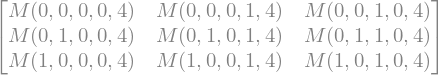


Explicit form with integrated kernel: 

First calculation of PMatrix_Singlet with:    [1, 0, 4, 'StandardCutoff']


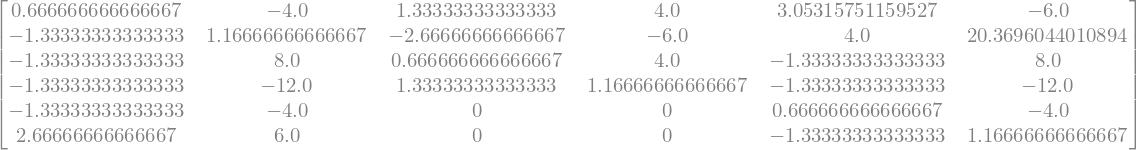

In [ ]:
 # Construction of the Singlet-PMatrix
def PMatrix(M_max, N_min, Nf_num, cutoffnmaxfct=CutoffFct,  Mat=ExplicitSplitFunMatrix ):
    global memory_PMatrix
     # get the name of the cut-off function
    cutoff_name = cutoffnmaxfct(0,0,True)[1]
    if (M_max, N_min, Nf_num, cutoff_name) in memory_PMatrix:
        return memory_PMatrix[(M_max, N_min, Nf_num, cutoff_name)]
     # if not, insert master integrals in the splitting function matrix
    else:
        print("First calculation of PMatrix_Singlet with:    "+str([M_max, N_min, Nf_num, cutoff_name]) )
        result = np.vstack([ np.hstack(PMatrixRow(Mat, M, N, M_max, N_min, Nf_num, cutoffnmaxfct ))
                        for M in range(0, M_max + 1  ) for  N in range(N_min, cutoffnmaxfct(M_max, M) + 1) ])
        memory_PMatrix[(M_max, N_min, Nf_num, cutoff_name)] = result
        return result




 # Example
memory_PMatrix = {}
print("Schematic form of the P-matrix for cutofflog = 1, cutoffx = 0 and Nf = 4:" + "\n")
display( sp.Matrix(PMatrix(1, 0, 4, CutoffFct, Matrix)))
memory_PMatrix = {}
print("\n"+"Explicit form with integrated kernel: "+ "\n")
display(sp.Matrix(PMatrix(1, 0, 4)))

$\,$

### The Non-Singlet $\mathcal{P}$-Matrix

Since at LO all non-singlet PDFs evolve with $P_{qq}^{(0)}$, we can derive the non-singlet evolution matrix from the singlet matrix by considering only the first entry of the splitting function matrix. Therefore, we simply build **PMatrix_NonSinglet** analogously to **PMatrix**, but out of that component only.

Schematic form of the P-matrix for cutofflog = 1, cutoffx = 0 and Nf = 4:

First calculation of PMatrix_Singlet with:    [1, 0, 4, 'StandardCutoff']


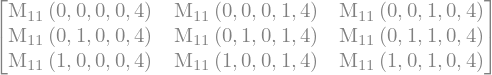


Explicit form with integrated kernel:
First calculation of PMatrix_NonSinglet with: [1, 0, 4, 'StandardCutoff']


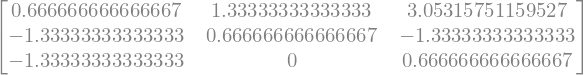

In [ ]:
 # Construction of the non-singlet P-matrix
def PMatrix_NonSinglet(M_max, N_min, Nf_num, cutoffnmaxfct=CutoffFct,  Mat_NonSinglet= ExplicitSplitFunMatrix):
     # get the first component of the splitting matrix
    Mat = lambda M,N,i,j,Nf: Mat_NonSinglet(M,N,i,j,Nf)[0][0]
     # analogous to the singlet case
    global memory_PMatrix_NonSinglet
    cutoff_name = cutoffnmaxfct(0,0,True)[1]
    if (M_max, N_min, Nf_num, cutoff_name) in memory_PMatrix_NonSinglet:
        return memory_PMatrix_NonSinglet[(M_max, N_min, Nf_num, cutoff_name)]
    else:
        print("First calculation of PMatrix_NonSinglet with: "+str([M_max, N_min, Nf_num, cutoff_name]) )
        result =  result = np.vstack([ np.hstack(PMatrixRow(Mat, M, N, M_max, N_min, Nf_num, cutoffnmaxfct ))
                        for M in range(0, M_max + 1  ) for  N in range(N_min, cutoffnmaxfct(M_max, M) + 1) ])
        memory_PMatrix_NonSinglet[(M_max, N_min, Nf_num, cutoff_name)] = result
        return result

 # Example, to indicate the structure
memory_PMatrix = {}
print("Schematic form of the P-matrix for cutofflog = 1, cutoffx = 0 and Nf = 4:" + "\n")
display( sp.Matrix(PMatrix(1, 0, 4, CutoffFct, Matrix_11)))
memory_PMatrix = {}
 # Example, non-singlet case
print("\n"+"Explicit form with integrated kernel:")
display(sp.Matrix(PMatrix_NonSinglet(1, 0, 4)))


$\,$

$\,$

# Parametrisation of the Initial PDF

To evolve the initial PDF at scale $\mu_0^2$ to a final scale $\mu^2$, we must first parametrize the initial PDF in terms of our spanning functions $\frac{\ln^m(x)}{m!}\, x^n$.  

Note that this parametrization is NOT unique as we could always write $x^n \,=\, \sum_{k=0}^{\infty} n^k \frac{\ln^k(x)}{k!}$ .  How exactly this parametrization in terms of spanning functions is determined will depend on the initial PDF.

If the initial PDF contains $x^{\alpha}$, the parametrization in terms of a finite set spanning functions will give a better approximation if $x^{\lfloor \alpha \rfloor}$ or  $x^{\lceil \alpha \rceil}$ are included in this finite set of spanning functions. We will therefore assume that these powers are indeed included and build **InitialConditionVector(Non)Singlet** to work on real powers of $x$ and positive integer powers of $\log$.

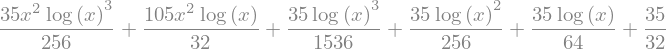

In [ ]:
 # Pattern-Matching variables, case differentiation betweeen positive and negative sign for non-integer powers
n_int = sp.Wild('n_int', exclude=[x], properties=[lambda k: k.is_Integer])
m_int = sp.Wild('m_int', exclude=[x], properties=[lambda k: k.is_Integer])
n_neg_non_int = sp.Wild('n_neg_non_int', exclude=[x,0], properties=[lambda k: k.is_negative and not(k.is_Integer)])
n_pos_non_int = sp.Wild('n_pos_non_int', exclude=[x,0], properties=[lambda k: k.is_nonnegative and not(k.is_Integer)])

 # express the initial PDF through the basis functions in a given order
def ExpandInBasis(expr, order):
    if expr==0:
         return 0
    else:
        expr_expanded = expr.series(x, x0=0, n=order).removeO().expand()
        expr_with_integer_exponents=expr_expanded.replace( x**n_neg_non_int, lambda n_neg_non_int: expansion_neg(n_neg_non_int, order)
                                            ).replace( x**n_pos_non_int, lambda n_pos_non_int: expansion_pos(n_pos_non_int, order)
                                            ).expand()
        return expr_with_integer_exponents

 # expansions of the non-integer powers, used in "ExpandInBasis"
def expansion_neg(n,order):
    n_float_part, n_integer_part = math.modf(n)
    return sum([n_float_part**j/ sp.factorial(j)  *  (sp.log(x))**j * x**n_integer_part for  j in range(0, order + 1) ])

def expansion_pos(n,order):
    return sum([(n-round(n))**j/ sp.factorial(j)  *  (sp.log(x))**j * x**( round(n) ) for  j in range(0, order + 1) ])



 # example in order 3
example_pdf = x * 35/32 * (1-x)**3 / sp.sqrt(x)
ExpandInBasis(example_pdf,3)

The PDF can thus be written as a vector in the base

Basis functions


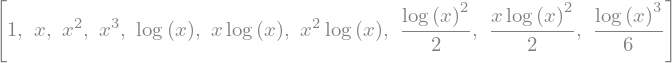

PDF as vector


In [ ]:
 # Expands the initial pdf in terms of the basis and transforms it into the corresponding vector
def InitialConditionVectorNonSinglet(expr, cutofflog, cutoffnmin, cutoffnmaxfct=CutoffFct):
     if expr==0:
         return [0 for n_logx in range(0, cutofflog + 1) for n_x in range(cutoffnmin, cutoffnmaxfct(cutofflog, n_logx) + 1)]
     else:
          expr_expanded_dictionary=ExpandInBasis(expr, cutofflog + 1).replace(sp.log(x), logx).as_coefficients_dict()
          return np.array([expr_expanded_dictionary[(logx**n_logx * x**n_x)] *math.factorial(n_logx)
                                for n_logx in range(0, cutofflog + 1) for n_x in range(cutoffnmin, cutoffnmaxfct(cutofflog, n_logx) + 1)])

 # example from above in order 3
example_pdf = x * 35/32 * (1-x)**3 / sp.sqrt(x)
print("Basis functions")
display(BasisFunctions(3,0))
print("PDF as vector")
sp.Matrix(InitialConditionVectorNonSinglet(example_pdf, 3, 0)).transpose()

In the singlet case, the same method can be used to parametrise the singlet quark and gluon distribution simultaneously. Note that **InitialConditionVectorSinglet** hands back a 2 row vector where the first row contains the quark coefficients, while the second row contains the gluon coefficients.

Basis functions


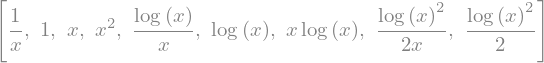

PDF as vector


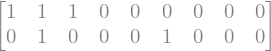

In [ ]:
 # Expands the initial pdf [q(µ0^2),g(µ0^2)] in terms of the basis and transforms it into the corresponding vector
def InitialConditionVectorSinglet(lst, cutofflog, cutoffnmin, cutoffnmaxfct=CutoffFct):
     output_row1 = InitialConditionVectorNonSinglet(lst[0], cutofflog, cutoffnmin, cutoffnmaxfct)
     output_row2 = InitialConditionVectorNonSinglet(lst[1], cutofflog, cutoffnmin, cutoffnmaxfct)
     return np.array([ output_row1, output_row2])


 # example
example_quark_pdf = 1/x + 1 +  x
example_gluon_pdf = 1 + sp.log(x)
print("Basis functions")
display(BasisFunctions(2,-1))
print("PDF as vector")
display(sp.Matrix(InitialConditionVectorSinglet([example_quark_pdf, example_gluon_pdf], 2, -1)))

To transform the "vectorized" PDF back to a function, we multiply it with the appropriate basis functions,

Basis functions


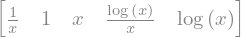

PDF as vector


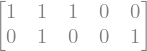

Result


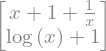

In [ ]:
 # Transform vector in basis to symbolic function
def VectorToFunction(vec, basis):
    return vec.dot(basis)

# example from above
basis_vec = BasisFunctions(1,-1)
pdf_vec = InitialConditionVectorSinglet([example_quark_pdf, example_gluon_pdf], 1, -1)
print("Basis functions")
display(sp.Matrix(basis_vec).transpose())
print("PDF as vector")
display(sp.Matrix(pdf_vec))
print("Result")
display(sp.Matrix(VectorToFunction(pdf_vec, basis_vec)))

Keep in mind that the singlet vector multiplying the $\mathcal{P}$-matrix should be written as $\left( a^{q^s}, a^g, ... , a^{q^s}_{m_{max}}, a^g_{m_{max}} \right)$. The following function performs this flattening of the  2-row singlet vector

Singlet vector as ((q1,q2,...),(g1, g2,...))


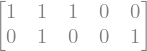

Singlet vector as (q1,g1,q2,g2,... )


In [ ]:
 # Flattened representation of the singlet vector
def SingletQuarkGluonVectorFlatten(vec):
    return vec.transpose().flatten()

#Example from above
example_quark_pdf = 1/x + 1 +  x
example_gluon_pdf = 1 + sp.log(x)
pdf_vec = InitialConditionVectorSinglet([example_quark_pdf, example_gluon_pdf], 1, -1)
print("Singlet vector as ((q1,q2,...),(g1, g2,...))")
display(sp.Matrix(pdf_vec))
print("Singlet vector as (q1,g1,q2,g2,... )")
display(sp.Matrix(SingletQuarkGluonVectorFlatten(pdf_vec)).transpose())

The following function reverses the flattening

Singlet vector as (q1,g1,q2,g2,... )


Singlet vector as ((q1,q2,...),(g1, g2,...))


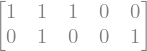

In [ ]:
def SingletQuarkGluonVectorUnFlatten(vec):
    return np.array([vec[i:i + 2] for i in range(0, len(vec), 2)]).transpose()


#Example
example_quark_pdf = 1/x + 1 +  x
example_gluon_pdf = 1 + sp.log(x)
pdf_vec = InitialConditionVectorSinglet([example_quark_pdf, example_gluon_pdf], 1, -1)
pdf_vec_flattened = SingletQuarkGluonVectorFlatten(pdf_vec)
print("Singlet vector as (q1,g1,q2,g2,... )")
display(sp.Matrix(pdf_vec_flattened).transpose())
print("Singlet vector as ((q1,q2,...),(g1, g2,...))")
sp.Matrix(SingletQuarkGluonVectorUnFlatten( pdf_vec_flattened ))

For the singlet evolution, we include $1/x$ among the basis functions, while for the non-singlet evolution we only include non-negative powers of $x$ (compare eqs. (3.4) and (3.11)).
Therefore, a function for the base change is required.
The idea is that singlet and non-singlet PDFs are written as a vector in a larger common base after the evolution.
The following function returns a corresponding transformation matrix:

Basis 1 with cardinality 6: 


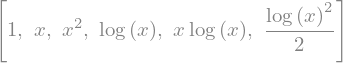

Vector in basis 1


Basis 2 with cardinality 14: 


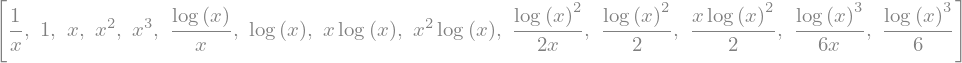

Vector in basis 2


Transformation matrix: 


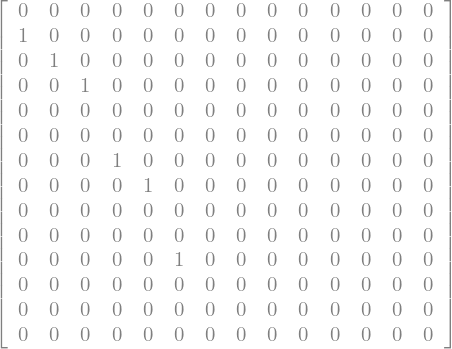

In [ ]:
 # Transformation matrix to rewrite vector into larger common_base
def change_basis_matrix(initial_basis, common_basis):
     # append zeros to vec until dimension of common basis is reached
    initial_basis_with_zeros= initial_basis[:]
    while len(initial_basis_with_zeros) < len(common_basis):
        initial_basis_with_zeros.append(0)
     # create transformation matrix
    return np.array([ [  1 if (initial_basis_with_zeros[i] == common_basis[j]) else 0 \
                         for i in range(0,len(common_basis))] for j in range(0,len(common_basis))  ])


 # rewrite vector into larger base using the transformation matrix
def rewrite_in_common_basis(vec, matrix):
     # append zeros to vec until dimension of common basis is reached
    initial_vec_with_zeros= vec[:]
    while len(initial_vec_with_zeros) < len(matrix):
        initial_vec_with_zeros = np.append(initial_vec_with_zeros, 0)
     # multiply the vector with the transformation matrix
    return np.dot(matrix,initial_vec_with_zeros)



# example
cutofflog_1 = 2; cutofflog_2 = 3; cutoffxmin_1 = 0; cutoffxmin_2 = -1

basis_1 = BasisFunctions(cutofflog_1,cutoffxmin_1)
basis_2 = BasisFunctions(cutofflog_2,cutoffxmin_2)
transformation_matrix = change_basis_matrix(basis_1, basis_2)

 # vector in basis 1
example_pdf =  x * 35/32 * (1-x)**3 / sp.sqrt(x)
vector_in_basis_1 = np.array(InitialConditionVectorNonSinglet(example_pdf, cutofflog_1, cutoffxmin_1))

 # rewritten in basis 2
vector_in_basis_2 = rewrite_in_common_basis(vector_in_basis_1, transformation_matrix)

print("Basis 1 with cardinality "+str(len(basis_1))+ ": ")
display(basis_1)
print("Vector in basis 1")
display(sp.Matrix(vector_in_basis_1).transpose())
print("Basis 2 with cardinality "+str(len(basis_2))+ ": ")
display(basis_2)
print("Vector in basis 2")
display(sp.Matrix(vector_in_basis_2).transpose())
print("Transformation matrix: ")
display(sp.Matrix(transformation_matrix))

$\,$

# Functions for Evolution

For the evolution, we must integrate the running coupling given by eq. (C.7) over $\mu$, which can be done numerically,

In [ ]:
 # Implementation of alpha_S in LO and NLO
def alphaS(Q2, LambdaQCD, Nf, order_alphaS):
    logQ2LQCD = sp.log(Q2 / LambdaQCD**2  )
    if order_alphaS == 1:
        loglogQ2LQCD = sp.log(logQ2LQCD)
        return (    4 * pi  / (  beta0(Nf) * logQ2LQCD  )
                 * (1 - (beta1(Nf) * loglogQ2LQCD ) /( beta0(Nf)**2 * logQ2LQCD)))
    else:
        return 4 * pi  / (  beta0(Nf) * logQ2LQCD  )

def beta0(Nf):
    return 11-2/3 * Nf

def beta1(Nf):
    return 102-38/3 * Nf


 # numerical integration of the running coupling
def alphaS_Integral_Numeric(mu, mu0, Nf, LambdaQCD, order_alphaS):
    return (integrate.quad(lambda Q2: alphaS(Q2, LambdaQCD, Nf, order_alphaS)/Q2 ,  mu0**2, mu**2   ))[0]

For the evolution across thresholds, we use the following code (compare appendix C).

In [ ]:
 # Numeric values for the thresholds (in GeV^2)
Threshold_Q2_values = [1.960, 20.25, 30625]

 # numeric values for in regions defined by thresholds (in GeV)
LambdaQCD_values = [0.204, 0.175, 0.132, 0.0665]
 #NLO: LambdaQCD_values = [0.2994, 0.2460, 0.1677, 0.0678]


 # appropriate number of active flavours
def Nf_scale_dependent(mu):
    Threshold = lambda n: np.sqrt(Threshold_Q2_values[n-3])
    if mu < Threshold(3): return 3
    if Threshold(3) <= mu < Threshold(4): return 4
    if Threshold(4) <= mu < Threshold(5): return 5
    if mu > Threshold(5): return 6

 # LambdaQCD as function of Nf
def LambdaQCD(Nf):
    return LambdaQCD_values[(Nf-3)]

$\,$

## Non-Singlet Evolution

The complete non-singlet evolution is given by eq. (3.7) and performed by the following routine. It takes the non-singlet initial PDF as a vector, calculates the corresponding $\mathcal{P}$-matrix and the $\alpha_s$-integral and forms the corresponding matrix exponential. This exponential is then multiplied by the vector and thus evolves the PDF. The output of the function is also a vector in the chosen basis.

In [ ]:
 # Evolves the non-singlet pdf as vector, fixed flavour
def NonSingletPdfsEvolved_Vector(mu, mu0, Nf, initial_pdf_vector, cutofflog, cutoffxmin, cutoffxmaxfct=CutoffFct, LambdaQCD=0.34, order_alphaS=0 ):
     # calculation of the P-matrix
    p_matrix = PMatrix_NonSinglet(cutofflog, cutoffxmin, Nf, cutoffxmaxfct)
     # numerical integration of the alpha_S integral
    alphaS_integrated = alphaS_Integral_Numeric(mu, mu0, Nf, LambdaQCD, order_alphaS)
     # get matrix exponential
    matrix_exponential = scipylin.expm( 1/(2*pi) * alphaS_integrated * p_matrix )
     # return new vector
    result = blas.dgemv(1, matrix_exponential,initial_pdf_vector)
    return  result


To illustrate this, the full non-singlet evolution process (without thresholds) is demonstrated by the following function using an example

First calculation of PMatrix_NonSinglet with: [3, 0, 3, 'StandardCutoff']


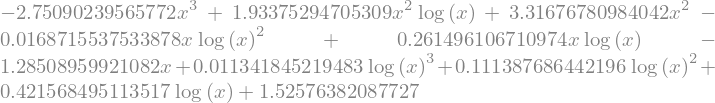

In [ ]:
 # Performs the fixed flavour non-singlet evolution
def NonSingletPdfsEvolved(mu, mu0, Nf, pdfs_at_mu0, cutofflog, cutoffxmin, cutoffxmaxfct=CutoffFct, LambdaQCD=0.34, order_alphaS=0 ):
     # write the initial pdf as vector in the chose base
    initial_pdf_list= InitialConditionVectorNonSinglet(pdfs_at_mu0, cutofflog, cutoffxmin,cutoffxmaxfct)
    initial_pdf_vector = np.array(initial_pdf_list)
     # provides a set of basis functions
    basis_functions = BasisFunctions(cutofflog, cutoffxmin, cutoffxmaxfct )
     # evolves the non-singlet pdf as vector, fixed flavour
    evolved_pdf_vec = NonSingletPdfsEvolved_Vector( mu, mu0, Nf, initial_pdf_vector, cutofflog,
                                                    cutoffxmin, cutoffxmaxfct, LambdaQCD, order_alphaS )
     # returns the pdf as a symbolic function
    return VectorToFunction(evolved_pdf_vec, basis_functions)





 # example
example_NonSinglet_pdf =  x * 35/32 * (1-x)**3 / sp.sqrt(x)

example_Q0 = 2
example_Q1 = 100
example_cutofflog   = 3
example_cuttoffxmin = 0
example_Nf = 3

result_example_NonSinglet_pdf=NonSingletPdfsEvolved(example_Q1, example_Q0, example_Nf, example_NonSinglet_pdf,
                                                                            example_cutofflog, example_cuttoffxmin)
display(result_example_NonSinglet_pdf)

The following function performs a full evolution respecting thresholds:

In [ ]:
 # Input: PDF as vector in basis, Output: evolved PDF as vector
def Evolution_Complete_NonSinglet(mu, mu0, pdfs_at_mu0, cutofflog, cutoffxmin, cutoffxmaxfct=CutoffFct, order_alphaS=0 ):
     # import the list of Thresholds
    global Threshold_Q2_values
    Threshold = lambda n: np.sqrt(Threshold_Q2_values[n-3])

     # sets the initial parameters for the evolution
    mu_start  = mu0
    nf_start  = Nf_scale_dependent(mu0)
    nf_final  = Nf_scale_dependent(mu)
    pdf_start = pdfs_at_mu0

     # performs the evolution between the thresholds
    while nf_start != nf_final:

        if nf_start < nf_final:

            evolved_pdf = NonSingletPdfsEvolved_Vector(Threshold( nf_start ), mu_start, nf_start, pdf_start,
                             cutofflog, cutoffxmin, cutoffxmaxfct, LambdaQCD(nf_start), order_alphaS  )
            mu_start = Threshold(nf_start)
            nf_start += 1
            pdf_start = evolved_pdf

        elif nf_start > nf_final:

            evolved_pdf = NonSingletPdfsEvolved_Vector(Threshold( nf_start -1), mu_start, nf_start, pdf_start,
                             cutofflog, cutoffxmin, cutoffxmaxfct, LambdaQCD(nf_start), order_alphaS  )
            mu_start = Threshold(nf_start - 1)
            nf_start -= 1
            pdf_start = evolved_pdf

    evolved_pdf = NonSingletPdfsEvolved_Vector(mu, mu_start, nf_start, pdf_start,
                             cutofflog, cutoffxmin, cutoffxmaxfct, LambdaQCD(nf_start), order_alphaS  )

     # returns the evolved pdf as a vector
    return evolved_pdf




#Example
example_NonSinglet_pdf =  x * 35/32 * (1-x)**3 / sp.sqrt(x)

example_Q0 = 2
example_Q1 = 1000
example_cutofflog   = 3
example_cuttoffxmin = 0

example_NonSinglet_pdf_vec = np.array(InitialConditionVectorNonSinglet(example_NonSinglet_pdf, example_cutofflog,
                                                                       example_cuttoffxmin, CutoffFct))

sp.Matrix( Evolution_Complete_NonSinglet(example_Q1, example_Q0, example_NonSinglet_pdf_vec,
                                               example_cutofflog, example_cuttoffxmin) ).transpose()

First calculation of PMatrix_NonSinglet with: [3, 0, 4, 'StandardCutoff']
First calculation of PMatrix_NonSinglet with: [3, 0, 5, 'StandardCutoff']
First calculation of PMatrix_NonSinglet with: [3, 0, 6, 'StandardCutoff']


$\,$

$\,$

## Singlet Evolution

The same can now be done for the singlet evolution:

First calculation of PMatrix_Singlet with:    [1, -1, 3, 'StandardCutoff']


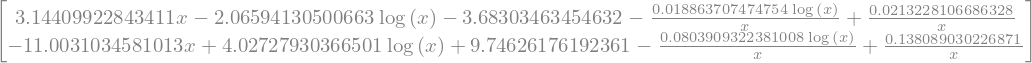

In [ ]:
 # Evolves the singlet pdf as vector, fixed flavour
def SingletPdfsEvolved_Vector(mu, mu0, Nf, initial_pdf_vector, cutofflog, cutoffxmin, cutoffxmaxfct=CutoffFct, LambdaQCD=0.34, order_alphaS=0 ):
     # calculation of the P-matrix
    p_matrix = PMatrix(cutofflog, cutoffxmin, Nf, cutoffxmaxfct)
     # numerical integration of the alpha_s integral
    alphaS_integrated = alphaS_Integral_Numeric(mu, mu0, Nf, LambdaQCD, order_alphaS)
     # get matrix exponential
    matrix_exponential = scipylin.expm( 1/(2*pi) * alphaS_integrated * p_matrix )
     # return new vector
    result = blas.dgemv(1, matrix_exponential,initial_pdf_vector)
    return  result


 # performs the fixed flavour singlet evolution
def SingletPdfsEvolved(mu, mu0, Nf, pdfs_at_mu0, cutofflog, cutoffxmin, cutoffxmaxfct=CutoffFct, LambdaQCD=0.34, order_alphaS=0 ):
    initial_pdf_vec = np.array(InitialConditionVectorSinglet([pdfs_at_mu0[0], pdfs_at_mu0[1]], cutofflog, cutoffxmin,cutoffxmaxfct))
    initial_pdf_vec_flattened = SingletQuarkGluonVectorFlatten(initial_pdf_vec)
    basis_functions = BasisFunctions(cutofflog, cutoffxmin, cutoffxmaxfct )

    evolved_pdf_vec = SingletPdfsEvolved_Vector( mu, mu0, Nf, initial_pdf_vec_flattened, cutofflog,
                                                    cutoffxmin, cutoffxmaxfct, LambdaQCD, order_alphaS )
    unflattened_evolved_pdf_vec = SingletQuarkGluonVectorUnFlatten(evolved_pdf_vec)
    return VectorToFunction(unflattened_evolved_pdf_vec, basis_functions)


# example
example_singlet_pdf =  [ 35/32 *x* (1-x)**3 / sp.sqrt(x), 0 ]

example_Q0 = 2
example_Q1 = 100
example_cutofflog   = 1
example_cuttoffxmin = -1
example_Nf = 3

evolved_example_pdf=SingletPdfsEvolved(example_Q1, example_Q0, example_Nf, example_singlet_pdf, example_cutofflog, example_cuttoffxmin)
display(sp.Matrix(evolved_example_pdf))

Analogous to the non-singlet case, the following function performs the full singlet evolution respecting thresholds:

In [ ]:
 # Input: PDF as flattened vector, Output: flattened vector
def Evolution_Complete_Singlet(mu, mu0, pdfs_at_mu0, cutofflog, cutoffxmin, cutoffxmaxfct=CutoffFct, order_alphaS=0 ):
    # import the list of Thresholds
    global Threshold_Q2_values
    Threshold = lambda n: np.sqrt(Threshold_Q2_values[n-3])

     # sets the initial parameters for the evolution
    mu_start = mu0
    nf_start = Nf_scale_dependent(mu0)
    nf_final = Nf_scale_dependent(mu)
    pdf_start = pdfs_at_mu0

     # performs the evolution between the thresholds
    while nf_start != nf_final:

        if nf_start < nf_final:

            evolved_pdf = SingletPdfsEvolved_Vector( Threshold( nf_start ), mu_start, nf_start, pdf_start,
                                               cutofflog, cutoffxmin, cutoffxmaxfct, LambdaQCD(nf_start), order_alphaS )
            mu_start = Threshold(nf_start)
            nf_start += 1
            pdf_start = evolved_pdf

        elif nf_start > nf_final:

            evolved_pdf = SingletPdfsEvolved_Vector( Threshold( nf_start-1 ), mu_start, nf_start, pdf_start,
                                               cutofflog, cutoffxmin, cutoffxmaxfct, LambdaQCD(nf_start), order_alphaS )
            mu_start = Threshold(nf_start - 1)
            nf_start -= 1
            pdf_start = evolved_pdf

    evolved_pdf_vec= SingletPdfsEvolved_Vector( mu, mu_start, nf_start, pdf_start,
                               cutofflog, cutoffxmin, cutoffxmaxfct, LambdaQCD(nf_start), order_alphaS )

    # returns the evolved pdf as flattened vector
    return evolved_pdf_vec






# example
example_Singlet_pdf =  [ x * 35/32 * (1-x)**3 / sp.sqrt(x), 0 ]

example_Q0 = 1
example_Q1 = 100
example_cutofflog   = 4
example_cuttoffxmin = -1

initial_pdf_vec_example = np.array(InitialConditionVectorSinglet(example_Singlet_pdf, example_cutofflog, example_cuttoffxmin, CutoffFct))
pdf_start_example = SingletQuarkGluonVectorFlatten(initial_pdf_vec_example)

example_result_vector=Evolution_Complete_Singlet(example_Q1, example_Q0, pdf_start_example, example_cutofflog, example_cuttoffxmin)
display(sp.Matrix(example_result_vector).transpose())

First calculation of PMatrix_Singlet with:    [4, -1, 3, 'StandardCutoff']
First calculation of PMatrix_Singlet with:    [4, -1, 4, 'StandardCutoff']
First calculation of PMatrix_Singlet with:    [4, -1, 5, 'StandardCutoff']


$\,$

# Full Example: Evolution of the GRV98 PDF-Set

The GRV98 leading order input distributions at initial scale $\mu_0^2 = 0.26\,\mathrm{GeV}^2$ are (compare appendix C)

In [ ]:
 #Input PDFs GRV98, LO, initial scale mu2_FRV98 in GeV^2
mu2_GRV98 = 0.26
uv_Initial                     = 1.239*x**(0.48 - 1)*(1 - x)**2.72*(1 - 1.8*sp.sqrt(x) + 9.5*x)
dv_Initial                     = 0.614*(1 - x)**0.9 * uv_Initial
delta_Initial                  = 0.23*x**(0.48 - 1)*(1 - x)**11.3*(1 - 12 * sp.sqrt(x) + 50.9*x)
ubar_dbar_minus_ssbar_Initial  = 1.52*x**(0.15 - 1)*(1 - x)**9.1*(1 - 3.6 * sp.sqrt(x) + 7.8*x)
g_Initial                      = 17.47*x**(1.6 - 1)*(1 - x)**3.8
ssbar_Initial                  = 0

To perform the full evolution of the complete PDF set, we now define the **POMPOM** routine.
This function combines the initial PDFs into one singlet and three non-singlet PDFs, and then evolves them using the POMPOM method.
\
\
If **return_vectors_only** is set to true, the evolved vectors of coefficients $a_{mn}$ are returned.
By default, the **return_vectors_only** flag is set to False, and the output are the full PDFs at scale $\mu$ as numerical functions in $x$, that is they can be called for numeric $x$.
\
\
If **for_plotting** is set to True (default), the PDFs are scaled by additional factors and multiplied by $x$. If **for_plotting** is set to false, the PDFs are returned without scaling and multiplication by $x$.

In [ ]:
 # Evolution of the GRV98 Set respecting thresholds, output either as vector in common basis or numerical function
def POMPOM(mu, N_basis, cutoffxmaxfct=CutoffFct, for_plotting=True, return_vectors_only=False):

     global memory_GRV98Vectors, memory_basis

     # import GRV98 pdfs
     global uv_Initial
     global dv_Initial
     global delta_Initial
     global ubar_dbar_minus_ssbar_Initial
     global g_Initial
     global ssbar_Initial
     global mu2_GRV98

      # identify initial scale
     mu_GRV98 = np.sqrt(mu2_GRV98)

      # get an appropriate Cutoff for N basis functions with respect to cutoffxmaxfct and the lower cutoffs
     cutoffnmin_Singlet = -1
     cutofflog_Singlet = CutoffLogFromTotalNumberOfBasisFunctions(N_basis, cutoffxmaxfct, cutoffnmin_Singlet)
     cutoffnmin_NonSinglet = 0
     cutofflog_NonSinglet = CutoffLogFromTotalNumberOfBasisFunctions(N_basis, cutoffxmaxfct, cutoffnmin_NonSinglet)

      # definition of the singlet and non-singlet PDFs
     initial_Singlet_symbolic = [uv_Initial + dv_Initial + 2*ubar_dbar_minus_ssbar_Initial + 3*ssbar_Initial, g_Initial]
     initial_NonSinglet_1_symbolic = uv_Initial
     initial_NonSinglet_2_symbolic = dv_Initial
     initial_NonSinglet_3_symbolic = delta_Initial
     initial_NonSinglet_4_symbolic = ubar_dbar_minus_ssbar_Initial

      # get singlet and non-singlet PDFs as vector
     cutoff_name = cutoffxmaxfct(0,0,True)[1]

     if (N_basis, cutoff_name) in memory_GRV98Vectors:
          initial_Singlet, initial_NonSinglet_1, initial_NonSinglet_2, \
               initial_NonSinglet_3, initial_NonSinglet_4 =  memory_GRV98Vectors[(N_basis, cutoff_name)]
     else:
         print("First calculation of InitialConditionVector with:   "+str([N_basis, cutoff_name]) )
         initial_Singlet       =  SingletQuarkGluonVectorFlatten(InitialConditionVectorSinglet( initial_Singlet_symbolic,
                                                                                                       cutofflog_Singlet, cutoffnmin_Singlet, cutoffxmaxfct ))
         initial_NonSinglet_1  =  InitialConditionVectorNonSinglet(initial_NonSinglet_1_symbolic, cutofflog_NonSinglet, cutoffnmin_NonSinglet, cutoffxmaxfct  )
         initial_NonSinglet_2  =  InitialConditionVectorNonSinglet(initial_NonSinglet_2_symbolic, cutofflog_NonSinglet, cutoffnmin_NonSinglet, cutoffxmaxfct  )
         initial_NonSinglet_3  =  InitialConditionVectorNonSinglet(initial_NonSinglet_3_symbolic, cutofflog_NonSinglet, cutoffnmin_NonSinglet, cutoffxmaxfct  )
         initial_NonSinglet_4  =  InitialConditionVectorNonSinglet(initial_NonSinglet_4_symbolic, cutofflog_NonSinglet, cutoffnmin_NonSinglet, cutoffxmaxfct  )
         memory_GRV98Vectors[(N_basis, cutoff_name)] = initial_Singlet, initial_NonSinglet_1, initial_NonSinglet_2, \
                                              initial_NonSinglet_3, initial_NonSinglet_4

      # evolution
     evolved_Singlet      = Evolution_Complete_Singlet(    mu, mu_GRV98, initial_Singlet,      cutofflog_Singlet, cutoffnmin_Singlet, cutoffxmaxfct )
     evolved_NonSinglet_1 = Evolution_Complete_NonSinglet( mu, mu_GRV98, initial_NonSinglet_1, cutofflog_NonSinglet, cutoffnmin_NonSinglet, cutoffxmaxfct )
     evolved_NonSinglet_2 = Evolution_Complete_NonSinglet( mu, mu_GRV98, initial_NonSinglet_2, cutofflog_NonSinglet, cutoffnmin_NonSinglet, cutoffxmaxfct )
     evolved_NonSinglet_3 = Evolution_Complete_NonSinglet( mu, mu_GRV98, initial_NonSinglet_3, cutofflog_NonSinglet, cutoffnmin_NonSinglet, cutoffxmaxfct )
     evolved_NonSinglet_4 = Evolution_Complete_NonSinglet( mu, mu_GRV98, initial_NonSinglet_4, cutofflog_NonSinglet, cutoffnmin_NonSinglet, cutoffxmaxfct )

      # unflatten the singlet evolution
     unflattened_Singlet = SingletQuarkGluonVectorUnFlatten(evolved_Singlet)
     evolved_Singlet_quark = unflattened_Singlet[0]
     evolved_Singlet_gluon = unflattened_Singlet[1]

      # as the singlet evolution starts at nmin=-1 and the non-singlet evolution at nmin=0, the results are in a different basis. Therefore, a common basis is needed:
     if (N_basis, cutoff_name) in memory_basis:
          basis_Singlet, basis_NonSinglet, basis_common, Singlet_transformation_matrix, NonSinglet_transformation_matrix   =  memory_basis[(N_basis, cutoff_name)]
     else:
         print("First calculation of basis_common with:   "+str([N_basis, cutoff_name]) )
          # define a larger common basis: basis_common
         basis_Singlet    = BasisFunctions(cutofflog_Singlet, cutoffnmin_Singlet, cutoffxmaxfct)
         basis_NonSinglet = BasisFunctions(cutofflog_NonSinglet, cutoffnmin_NonSinglet, cutoffxmaxfct)
         largest_cutofflog   = max( cutofflog_Singlet,  cutofflog_NonSinglet  )
         smallest_cuttofxmin = min( cutoffnmin_Singlet, cutoffnmin_NonSinglet )
         basis_common     = BasisFunctions(largest_cutofflog, smallest_cuttofxmin, cutoffxmaxfct)
          # get transformation matrices
         Singlet_transformation_matrix    = change_basis_matrix(basis_Singlet, basis_common)
         NonSinglet_transformation_matrix = change_basis_matrix(basis_NonSinglet, basis_common)
         memory_basis[(N_basis, cutoff_name)] = basis_Singlet, basis_NonSinglet, basis_common, Singlet_transformation_matrix, NonSinglet_transformation_matrix

      # Singlet
     qS_evolved = rewrite_in_common_basis(evolved_Singlet_quark, Singlet_transformation_matrix)
     g_evolved  = rewrite_in_common_basis(evolved_Singlet_gluon, Singlet_transformation_matrix)
      # Non-Singlet
     common_evolved_NonSinglet_1  = rewrite_in_common_basis(evolved_NonSinglet_1, NonSinglet_transformation_matrix)
     common_evolved_NonSinglet_2  = rewrite_in_common_basis(evolved_NonSinglet_2, NonSinglet_transformation_matrix)
     common_evolved_NonSinglet_3  = rewrite_in_common_basis(evolved_NonSinglet_3, NonSinglet_transformation_matrix)
     common_evolved_NonSinglet_4  = rewrite_in_common_basis(evolved_NonSinglet_4, NonSinglet_transformation_matrix)


      # decouple evolved PDFs
     uv_evolved            = common_evolved_NonSinglet_1
     dv_evolved            = common_evolved_NonSinglet_2
     ssbar_evolved         = 1/3*( qS_evolved  - uv_evolved - dv_evolved - 2 * common_evolved_NonSinglet_4 )
     us_evolved            = 1/2*( qS_evolved  - ssbar_evolved  - uv_evolved  - dv_evolved - 2 * common_evolved_NonSinglet_3 )
     ds_evolved            = 1/2*( qS_evolved  - ssbar_evolved  - uv_evolved  - dv_evolved + 2 * common_evolved_NonSinglet_3 )


      # if flag is set true, return vectors without basis functions
     if return_vectors_only:
          return g_evolved, uv_evolved, us_evolved, dv_evolved, ds_evolved, ssbar_evolved
     else:
          pass

      # return the evolved PDFs as functions, for_plotting scales by additional factors and returns x*PDFs
     if for_plotting:
          g     = sp.lambdify( x,  0.01  * x* np.dot(  g_evolved      , basis_common ), modules=['scipy', 'numpy']  )
          uv    = sp.lambdify( x,  1     * x* np.dot(  uv_evolved     , basis_common ), modules=['scipy', 'numpy']  )
          dv    = sp.lambdify( x,  1     * x* np.dot(  dv_evolved     , basis_common ), modules=['scipy', 'numpy']  )
          ssbar = sp.lambdify( x,  0.1   * x* np.dot(  ssbar_evolved  , basis_common ), modules=['scipy', 'numpy']  )
          us    = sp.lambdify( x,  0.1   * x* np.dot(  us_evolved     , basis_common ), modules=['scipy', 'numpy']  )
          ds    = sp.lambdify( x,  0.1   * x* np.dot(  ds_evolved     , basis_common ), modules=['scipy', 'numpy']  )
     else:
          g     = sp.lambdify( x,  np.dot(  g_evolved      , basis_common ), modules=['scipy', 'numpy']  )
          uv    = sp.lambdify( x,  np.dot(  uv_evolved     , basis_common ), modules=['scipy', 'numpy']  )
          dv    = sp.lambdify( x,  np.dot(  dv_evolved     , basis_common ), modules=['scipy', 'numpy']  )
          ssbar = sp.lambdify( x,  np.dot(  ssbar_evolved  , basis_common ), modules=['scipy', 'numpy']  )
          us    = sp.lambdify( x,  np.dot(  us_evolved     , basis_common ), modules=['scipy', 'numpy']  )
          ds    = sp.lambdify( x,  np.dot(  ds_evolved     , basis_common ), modules=['scipy', 'numpy']  )

      # return results
     return g, uv, us, dv, ds, ssbar

$\,$

$\,$

$\,$

To demonstrate the program, **GRV98_POMPOM_Evolution** produces evolutions to five different scales and presents them in a common plot, similar to figure 4 of our paper.

In [ ]:
 # POMPOM evolution of the GRV98 PDF set
def GRV98_POMPOM_Evolution(N_basis_functions_plot, CutoffFct_plot ):

    #########################################################################################################
    #                                   Evolution to 5 different scales                                     #
    #########################################################################################################

     # Evolution scales: Q2 = 1, 10, 100, 10^4, 10^8 GeV^2
    Q1_plot2 = 1
    Q2_plot2 = 10
    Q3_plot2 = 100
    Q4_plot2 = 10**4
    Q5_plot2 = 10**8

     # determine scales from squared values
    Q1_plot = np.sqrt(Q1_plot2)
    Q2_plot = np.sqrt(Q2_plot2)
    Q3_plot = np.sqrt(Q3_plot2)
    Q4_plot = np.sqrt(Q4_plot2)
    Q5_plot = np.sqrt(Q5_plot2)

     # optional: show funny animation during evolution process
    from IPython.display import Image, clear_output
    display(Image(open('PyPOMPOM_Wait.gif','rb').read()))

     # perform the POMPOM evolution
    print("     Evolution Q1: ")
    g_Q1, uv_Q1, us_Q1, dv_Q1, ds_Q1, ssbar_Q1 = POMPOM(Q1_plot, N_basis_functions_plot, CutoffFct_plot)
    print("     Evolution Q2: ")
    g_Q2, uv_Q2, us_Q2, dv_Q2, ds_Q2, ssbar_Q2 = POMPOM(Q2_plot, N_basis_functions_plot, CutoffFct_plot)
    print("     Evolution Q3: ")
    g_Q3, uv_Q3, us_Q3, dv_Q3, ds_Q3, ssbar_Q3 = POMPOM(Q3_plot, N_basis_functions_plot, CutoffFct_plot)
    print("     Evolution Q4: ")
    g_Q4, uv_Q4, us_Q4, dv_Q4, ds_Q4, ssbar_Q4 = POMPOM(Q4_plot, N_basis_functions_plot, CutoffFct_plot)
    print("     Evolution Q5: ")
    g_Q5, uv_Q5, us_Q5, dv_Q5, ds_Q5, ssbar_Q5 = POMPOM(Q5_plot, N_basis_functions_plot, CutoffFct_plot)

     # optional: remove funny animation
    clear_output()

     # initial PDF
    Q0_plot2 = mu2_GRV98
    singlet_Q0 = uv_Initial + dv_Initial +    2*ubar_dbar_minus_ssbar_Initial + 3*ssbar_Initial
    g_Q0     = g_Initial
    uv_Q0    = uv_Initial
    dv_Q0    = dv_Initial
    ssbar_Q0 = ssbar_Initial
    us_Q0    = 1/2*( singlet_Q0  - ssbar_Q0  - uv_Q0  - dv_Q0 - 2 * delta_Initial )
    ds_Q0    = 1/2*( singlet_Q0  - ssbar_Q0  - uv_Q0  - dv_Q0 + 2 * delta_Initial )

    # generate plot data
    print("Generating the plots...")

     # x-values
    x_list = np.logspace(-4, 0, num = 10000)

    g_Q0_fun     = sp.lambdify( x, x  * 0.01  *     g_Q0 , modules=['scipy', 'numpy'] ) ;
    uv_Q0_fun    = sp.lambdify( x, x  * 1     *    uv_Q0 , modules=['scipy', 'numpy'] ) ;
    dv_Q0_fun    = sp.lambdify( x, x  * 1     *    dv_Q0 , modules=['scipy', 'numpy'] ) ;
    ssbar_Q0_fun = sp.lambdify( x, x  * 0.1   * ssbar_Q0 , modules=['scipy', 'numpy'] ) ;
    us_Q0_fun    = sp.lambdify( x, x  * 0.1   *    us_Q0 , modules=['scipy', 'numpy'] ) ;
    ds_Q0_fun    = sp.lambdify( x, x  * 0.1   *    ds_Q0 , modules=['scipy', 'numpy'] ) ;

    g_Q0_list     =      g_Q0_fun(x_list)    ;   g_Q1_list     =      g_Q1( x_list )
    uv_Q0_list    =     uv_Q0_fun(x_list)    ;   uv_Q1_list    =     uv_Q1( x_list )
    dv_Q0_list    =     dv_Q0_fun(x_list)    ;   dv_Q1_list    =     dv_Q1( x_list )
    ssbar_Q0_list =  ssbar_Q0_fun(x_list)    ;   ssbar_Q1_list =  ssbar_Q1( x_list )
    us_Q0_list    =     us_Q0_fun(x_list)    ;   us_Q1_list    =     us_Q1( x_list )
    ds_Q0_list    =     ds_Q0_fun(x_list)    ;   ds_Q1_list    =     ds_Q1( x_list )

    g_Q2_list     =      g_Q2( x_list )      ;   g_Q3_list     =      g_Q3( x_list )
    uv_Q2_list    =     uv_Q2( x_list )      ;   uv_Q3_list    =     uv_Q3( x_list )
    dv_Q2_list    =     dv_Q2( x_list )      ;   dv_Q3_list    =     dv_Q3( x_list )
    ssbar_Q2_list =  ssbar_Q2( x_list )      ;   ssbar_Q3_list =  ssbar_Q3( x_list )
    us_Q2_list    =     us_Q2( x_list )      ;   us_Q3_list    =     us_Q3( x_list )
    ds_Q2_list    =     ds_Q2( x_list )      ;   ds_Q3_list    =     ds_Q3( x_list )

    g_Q4_list     =      g_Q4( x_list )      ;   g_Q5_list     =      g_Q5( x_list )
    uv_Q4_list    =     uv_Q4( x_list )      ;   uv_Q5_list    =     uv_Q5( x_list )
    dv_Q4_list    =     dv_Q4( x_list )      ;   dv_Q5_list    =     dv_Q5( x_list )
    ssbar_Q4_list =  ssbar_Q4( x_list )      ;   ssbar_Q5_list =  ssbar_Q5( x_list )
    us_Q4_list    =     us_Q4( x_list )      ;   us_Q5_list    =     us_Q5( x_list )
    ds_Q4_list    =     ds_Q4( x_list )      ;   ds_Q5_list    =     ds_Q5( x_list )

     # initialize the plot routine
    plt.rc('text', usetex = True)
    fig, axs = plt.subplots(3, 2, figsize=(10,15))

     # definition of the plot-function to generate subplots
    def plot_subfig(x_list, g_list, uv_list, dv_list,ssbar_list, us_list, ds_list, posx, posy, title, label_flag ):
        axs[posx,posy].set_ylim([0.0001, 1])
        axs[posx,posy].grid()
        axs[posx,posy].set_title(title)
        axs[posx,posy].semilogx(x_list, g_list,      'r-', label = ( " $0.01 x g(x) $" if label_flag == True else None))
        axs[posx,posy].semilogx(x_list, uv_list,     'b-', label = ( " $ x  u_v(x)  $" if label_flag == True else None))
        axs[posx,posy].semilogx(x_list, dv_list,     'g-', label = ( " $ x  d_v(x)  $" if label_flag == True else None))
        try:
            axs[posx,posy].semilogx(x_list, ssbar_list, 'm-', label = ("$ 0.1 x (s(x) + sb(x)) $" if label_flag == True else None))
        except:
            pass
        axs[posx,posy].semilogx(x_list, us_list,     'c-', label = (" $0.01 x u_s(x) $" if label_flag == True else None))
        axs[posx,posy].semilogx(x_list, ds_list,     'y-', label = (" $0.01 x d_s(x) $" if label_flag == True else None))


    plot_subfig( x_list, g_Q0_list, uv_Q0_list, dv_Q0_list, ssbar_Q0_list, us_Q0_list, ds_Q0_list, 0, 0, \
                "Evolution to $\mu^2=$"+ str(Q0_plot2)+" GeV${}^2$" , False)
    plot_subfig( x_list, g_Q1_list, uv_Q1_list, dv_Q1_list, ssbar_Q1_list, us_Q1_list, ds_Q1_list, 0, 1, \
                "Evolution to $\mu^2=$"+ str(Q1_plot2)+" GeV${}^2$" , False)
    plot_subfig( x_list, g_Q2_list, uv_Q2_list, dv_Q2_list, ssbar_Q2_list, us_Q2_list, ds_Q2_list, 1, 0, \
                "Evolution to $\mu^2=$"+ str(Q2_plot2)+" GeV${}^2$" , False)
    plot_subfig( x_list, g_Q3_list, uv_Q3_list, dv_Q3_list, ssbar_Q3_list, us_Q3_list, ds_Q3_list, 1, 1, \
                "Evolution to $\mu^2=$"+ str(Q3_plot2)+" GeV${}^2$" , False)
    plot_subfig( x_list, g_Q4_list, uv_Q4_list, dv_Q4_list, ssbar_Q4_list, us_Q4_list, ds_Q4_list, 2, 0, \
                "Evolution to $\mu^2=$"+ str(Q4_plot2)+" GeV${}^2$" , False)
    plot_subfig( x_list, g_Q5_list, uv_Q5_list, dv_Q5_list, ssbar_Q5_list, us_Q5_list, ds_Q5_list, 2, 1, \
                "Evolution to $\mu^2=$"+ str(Q5_plot2)+" GeV${}^2$" , True)

    fig.suptitle('DGLAP evolution with POMPOM \n\n', fontsize=30)
    fig.legend()
    fig.tight_layout()
    plt.show()

The following cell starts the evolution

Generating the plots...


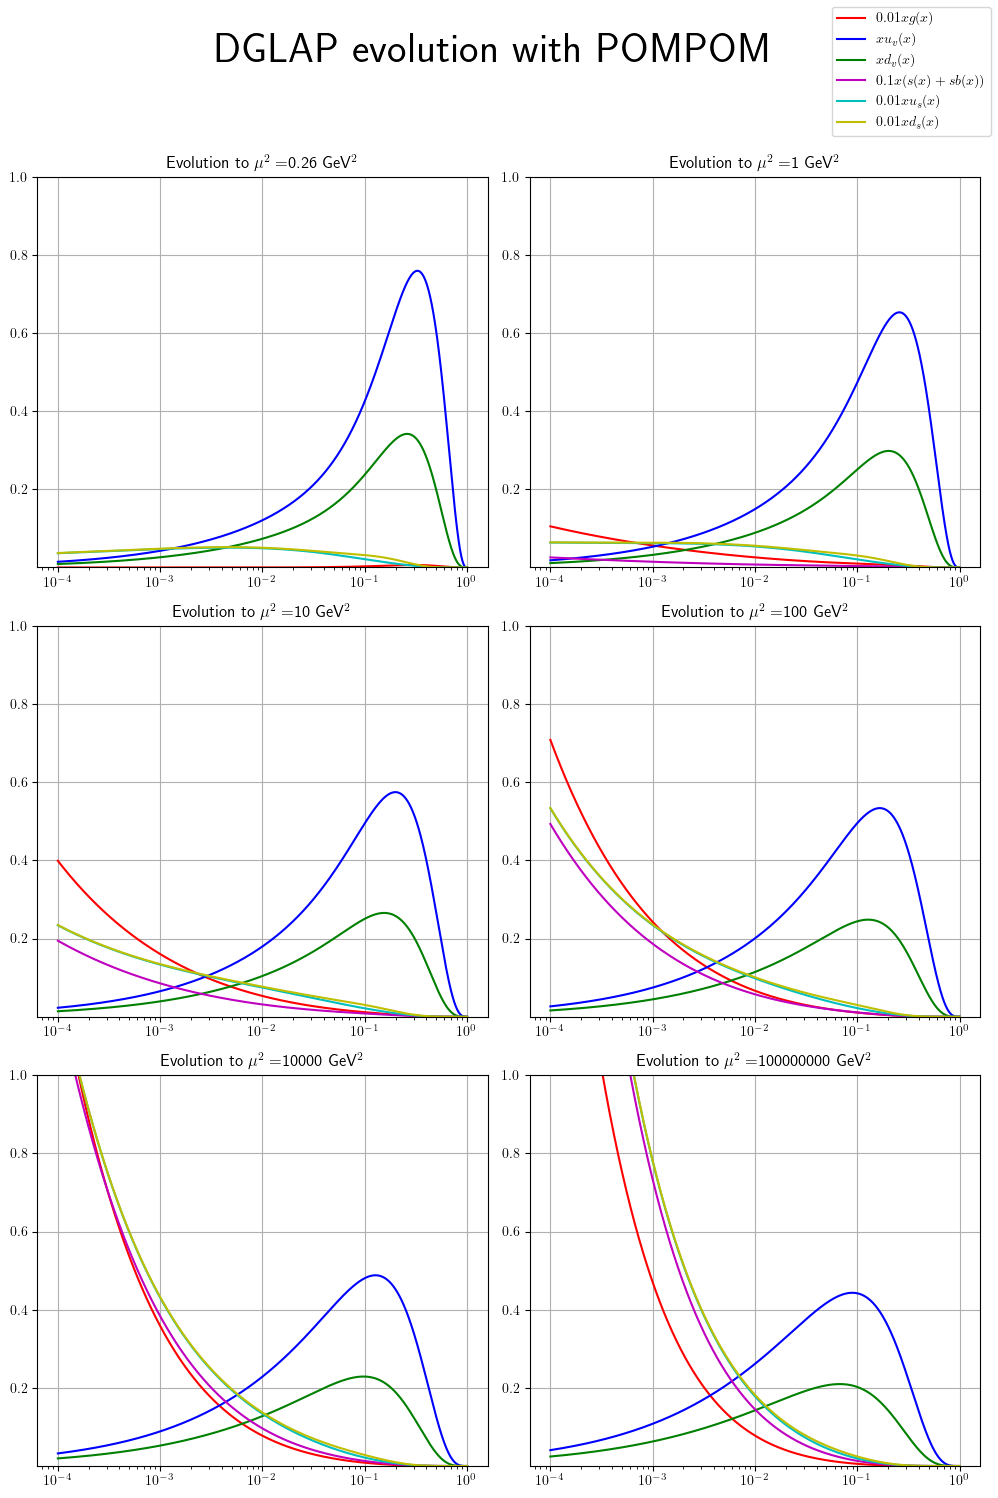

In [ ]:
 # Optional: Deletes the previous examples from the memory
reset_memory()

 # number of basis functions
N_basis_functions_plot = 200

 # linear Cutoff function
alpha_plot = 4
beta_plot =  3
CutoffFct_plot =  lambda i,j,flag=False : CutoffFctLinear(alpha_plot, beta_plot, i, j, flag)

 # start evolution
GRV98_POMPOM_Evolution(N_basis_functions_plot, CutoffFct_plot )

$\,$

To check the results, one can use the momentum and flavour sum rules given in eqs. (2.15) and (2.16) of our paper,

In [ ]:
 # Implementation of the numerical integration to check sum rules
def Flavour_SumRule(qns):
    return (integrate.quad(qns ,  0, 1   ))[0]

def Momentum_SumRule(qs):
    return (integrate.quad(lambda x: x*(qs[0](x)+qs[1](x)) ,  0, 1   ))[0]



  # output scale
QNorm2 = 1000

 # N basis functions
N_basis_functions_norm = 200

 # linear cutoff function
alpha_norm = 4
beta_norm  = 3
CutoffFct_norm =  lambda i,j,flag=False : CutoffFctLinear(alpha_norm, beta_norm, i,j, flag)

 # POMPOM-evolution
g_norm, uv_norm, us_norm, dv_norm, ds_norm, ssbar_norm = POMPOM(QNorm2, N_basis_functions_norm,CutoffFct_norm, False )

 # POMPOM results rearanged into singlet
norm_singlet_q = lambda x: uv_norm(x) + us_norm(x) + dv_norm(x) + ds_norm(x)  + ssbar_norm(x)

 # GRV98 singlet
initial_singlet = sp.lambdify( x, uv_Initial + dv_Initial + 2*ubar_dbar_minus_ssbar_Initial + 3*ssbar_Initial, modules=['scipy', 'numpy']  )
initial_gluon   = sp.lambdify( x,  g_Initial, modules=['scipy', 'numpy']  )

 # Get sum rule results of the initial PDF
true_value_momentum =  Momentum_SumRule([initial_singlet, initial_gluon])
true_value_flavour_u = Flavour_SumRule( sp.lambdify( x,  uv_Initial, modules=['scipy', 'numpy'] ))
true_value_flavour_d = Flavour_SumRule( sp.lambdify( x,  dv_Initial, modules=['scipy', 'numpy'] ))

 # check the momentum sum rule
SumRuleSinglet = Momentum_SumRule([norm_singlet_q, g_norm])
print("Momentum sum rule violation:  " +str( abs(SumRuleSinglet-true_value_momentum)*100 )+ " %" )

 # check the flavour sum rules
SumRule_uv = Flavour_SumRule( uv_norm )
SumRule_dv = Flavour_SumRule( dv_norm )
print("Flavour sum rule violation u: " +str( abs(SumRule_uv-true_value_flavour_u)*100 )+ " %" )
print("Flavour sum rule violation d: " +str( abs(SumRule_dv-true_value_flavour_d)*100 )+ " %" )

Momentum sum rule violation:  0.0007006207616733207 %
Flavour sum rule violation u: 0.00016047954729536684 %
Flavour sum rule violation d: 0.00017231553142149636 %


$\,$

$\,$

## Optional: Export for comparison

Creates a "Result.csv" file in which the coefficients of the GRV98 evolution are saved line by line

In [ ]:
"""
 # Number of basis functions
N_basis_functions_Test = 200

 # evolution scale
Q2Test = 10**8
QTest = np.sqrt(Q2Test)

 # linear Cutoff function
alpha_Test = 2
beta_Test  = 2
CutoffFct_Test =  lambda i,j,flag=False : CutoffFctLinear(alpha_Test, beta_Test, i, j, flag)



 # POMPOM evolution
g_Test, uv_Test, us_Test, dv_Test, ds_Test, ssbar_Test = POMPOM(QTest, N_basis_functions_Test,CutoffFct_Test, False, True )

 # save in .csv file
np.savetxt("Result.csv"\
           , (g_Test, uv_Test, us_Test, dv_Test, ds_Test, ssbar_Test), delimiter = ",", comments='',fmt='%64.64f')
print("Done")
"""

'\n # Number of basis functions\nN_basis_functions_Test = 200\n\n # evolution scale\nQ2Test = 10**8\nQTest = np.sqrt(Q2Test)\n\n # linear Cutoff function\nalpha_Test = 2\nbeta_Test  = 2\nCutoffFct_Test =  lambda i,j,flag=False : CutoffFctLinear(alpha_Test, beta_Test, i, j, flag)\n\n\n\n # POMPOM evolution\ng_Test, uv_Test, us_Test, dv_Test, ds_Test, ssbar_Test = POMPOM(QTest, N_basis_functions_Test,CutoffFct_Test, False, True )\n\n # save in .csv file\nnp.savetxt("Result.csv"           , (g_Test, uv_Test, us_Test, dv_Test, ds_Test, ssbar_Test), delimiter = ",", comments=\'\',fmt=\'%64.64f\')\nprint("Done")\n'